## **Contents**

<a href="#1.-Problem-overview">1. Problem overview</a><br>
<a href="#2.-Libraries">2. Libraries</a><br>
<a href="#3.-Reading-the-data">3. Reading the data</a><br>
<a href="#4.-Exploratory-Data-analysis">4. Exploratory Data-analysis</a><br>
<a href="#5.-Data-pre-processing">5. Data pre-processing</a><br>
<a href="#6.-Converting-features-into-numerical-vector">6. Converting features into numerical vector</a><br>
<a href="#7.-Model-building">7. Model building</a><br>
<a href="#8.-Model-comparison">8. Model comparison</a><br>
<a href="#9.-Conclusion">9. Conclusion</a>

## 1. Problem overview

Dataset: https://www.kaggle.com/uciml/sms-spam-collection-dataset

Here we are trying to predict if a new sms is spam or not spam (a binary classification problem). 

Sometimes its ok that an sms which is spam is not identified and ends up in our inbox. But its not ok that an important sms which is not spam end up in spam folder because we won't read the spam folder's sms.

So here we want to minimim value of false positive.

**Performance  metric:**
1. Accuracy
2. Confusion matrix


## **2. Libraries**

In [321]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

print("Libraries imported")

Libraries imported


## 3. Reading the data

In [322]:
df = pd.read_csv("spam.csv", encoding = "ISO-8859-1")

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Drop the unnecessary columns.**

In [323]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

**Changing the column names.**

In [324]:
df.columns = ["Label", "Text"]

df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [325]:
# ham = good sms, spam = bad sms

df.describe()

,Label,Text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [326]:
df.groupby("Label").describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [327]:
# making a new column with classes 0 (ham) and 1 (spam)

df["Spam"] = df["Label"].apply(lambda x: 0 if x == "ham" else 1)

df.head()

,Label,Text,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## 4. Exploratory data analysis

**Distribution of data points among output classes**

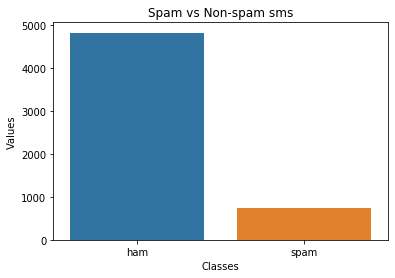

In [328]:
#df.groupby("Spam")["Label"].count().plot.bar()

x = list(df["Label"].value_counts().index)
y = df["Label"].value_counts()

plt.figure()
sns.barplot(x, y)

plt.title("Spam vs Non-spam sms")
plt.xlabel("Classes")
plt.ylabel("Values")
plt.show()

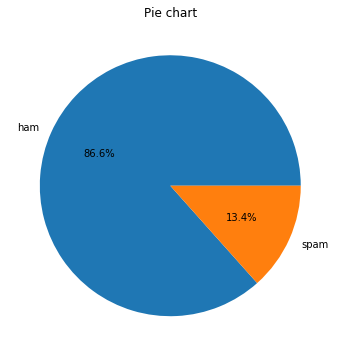

In [329]:
plt.figure(figsize=(6,6))
plt.pie(y, labels=x, autopct='%1.1f%%')

plt.title("Pie chart")
plt.show()

**Adding new feature lengh of the text**

In [330]:
df["Lengh"] = df["Text"].apply(len)

df.head()

,Label,Text,Spam,Lengh
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


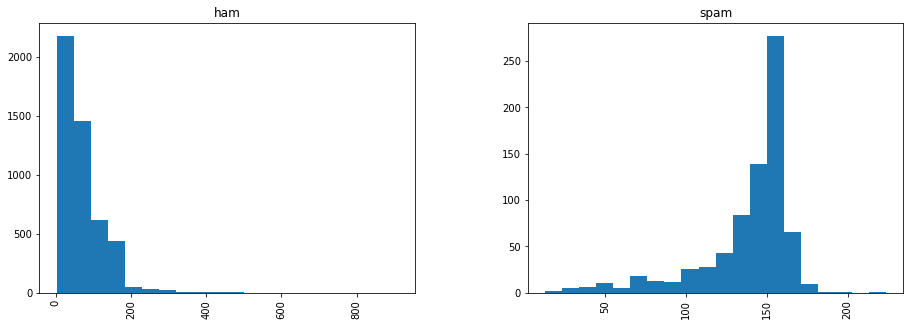

In [331]:
#plt.hist(df["Lengh"][df["Label"]=="ham"])

df.hist(by="Label", column='Lengh', figsize=[15,5], bins=20)
plt.show()

From the given histograms we can see that, **the lengh feature can be very helpful in classiying the data-points.**

## 5. Data pre-processing

1. converting into lower case
2. removing HTML tags
3. Expanding contractions
4. removing punctuations
5. removing stop words and stemming

In [332]:
def preprocess_text(sentence):
    """
    This function preprocesses text with various operations.
    """
    # 1. converting into lower case
    sentence = str(sentence).lower()
    
    # 2. removing HTML tags
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)
    
    # 3. Expanding contractions
    sentence = sentence.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    #sentence = re.sub(r"([0-9]+)000000", r"\1m", x)
    #sentence = re.sub(r"([0-9]+)000", r"\1k", x)
    
    # 4. removing punctuations
    pattern = re.compile('\W')
    
    if type(sentence) == type(''):
        sentence = re.sub(pattern, ' ', sentence)
        
    # 5. removing stop words and stemming
    stop_words = stopwords.words("english")
    porter = PorterStemmer()
    words = [porter.stem(word) for word in sentence.split() if word not in stop_words]
    
    # combining words into a sentence
    sentence = ' '.join(word for word in words)
    
    return sentence

In [333]:
df["Text"] = df["Text"].apply(lambda x: preprocess_text(x))

df.head()

,Label,Text,Spam,Lengh
0,ham,go jurong point crazi avail bugi n great world...,0,111
1,ham,ok lar joke wif u oni,0,29
2,spam,free entri 2 wkli comp win fa cup final tkt 21...,1,155
3,ham,u dun say earli hor u c alreadi say,0,49
4,ham,nah think goe usf live around though,0,61


## 6. Converting features into numerical vector

In [334]:
# spilitting the data
X_train, X_test, y_train, y_test = train_test_split(df["Text"], df["Spam"], test_size=0.3, random_state=1)

# 1. converting features into numerical values with BoW technique
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

X_train_transformed.shape

(3900, 5981)

## 7. Model building

In [335]:
def train_best_model(clf, hyperparameters, X, y):
    """
    This function find the best hyperparameters for the given algorithm and trains the data
    """
    model = GridSearchCV(clf, hyperparameters, cv=5, scoring="accuracy")
    best_model = model.fit(X, y)
    
    return best_model

def get_accuracy(clf, X_test, y_true):
    """
    This function returns accuracy score for given test data.
    """
    scores = []
    
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_true, y_pred))
    scores.append(confusion_matrix(y_true, y_pred).ravel()[1])
    
    print("Accuracy: ", scores[0])
    print("False positive: ", scores[1])
    
    return scores

**MultinomialNB**

In [336]:
scores = dict()

alpha_values = [0.1, 0.2, 0.3, 0.4, 0,5, 0.6, 0.7, 0.8, 0.9, 1.0]
hyperparameters = dict(alpha=alpha_values)

model_NB = train_best_model(MultinomialNB(), hyperparameters, X_train_transformed, y_train)
scores_NB = get_accuracy(model_NB, X_test_transformed, y_test)

scores["MultinomialNB"] = scores_NB

Accuracy:  0.9838516746411483
False positive:  4


**RandomForestClassifier**

In [337]:
n_values = [2,5,10,15,20,25] # if computation power this numbers can be increased

# this can also be adjusted if have more computation power
# max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
hyperparameters = dict(n_estimators=n_values)

model_RF = train_best_model(RandomForestClassifier(random_state=1), hyperparameters, X_train_transformed, y_train)
score_RF = get_accuracy(model_RF, X_test_transformed, y_test)

scores["RandomForest"] = score_RF

Accuracy:  0.9772727272727273
False positive:  2


**Supper Vector Machine (SVM)**

In [338]:
C_values = [0.1, 1, 10, 100, 1000]
gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]

# this can also be adjusted if have more computation power
# max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
hyperparameters = dict(C=C_values, gamma=gamma_values)

model_SVC = train_best_model(SVC(random_state=1), hyperparameters, X_train_transformed, y_train)
score_SVC = get_accuracy(model_SVC, X_test_transformed, y_test)

scores["SVM"] = score_SVC

Accuracy:  0.9874401913875598
False positive:  1


## **8. Models' comparison**

In [339]:
scores

{'MultinomialNB': [0.9838516746411483, 4],
 'RandomForest': [0.9772727272727273, 2],
 'SVM': [0.9874401913875598, 1]}

In [340]:
df_score = pd.DataFrame(data=scores.values(), columns=["Accuracy", "False-positive"], index=scores.keys())

df_score

,Accuracy,False-positive
MultinomialNB,0.983852,4
RandomForest,0.977273,2
SVM,0.987440,1


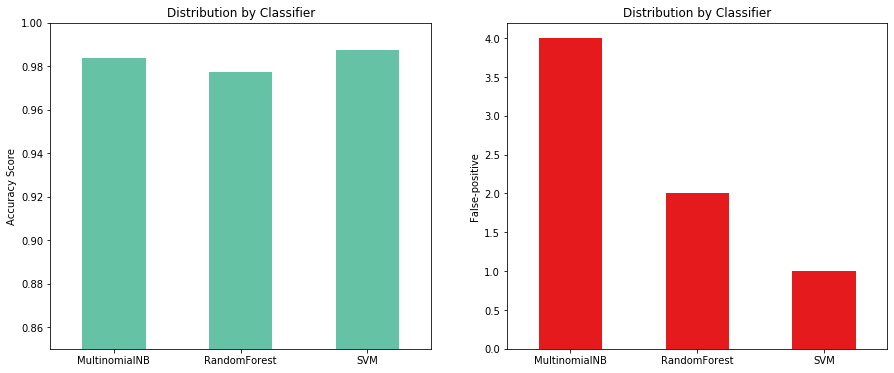

In [341]:
# plot 1
plt.subplot(1,2,1)

df_score["Accuracy"].plot(kind='bar', ylim=(0.85,1.0), figsize=(15,6), align='center', colormap="Set2")

plt.xticks(np.arange(3), df_score.index, rotation=360)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')

# plot 2
plt.subplot(1,2,2)

df_score["False-positive"].plot(kind='bar', figsize=(15,6), align='center', colormap="Set1")

plt.xticks(np.arange(3), df_score.index, rotation=360)
plt.ylabel('False-positive')
plt.title('Distribution by Classifier')

plt.show()

## 9. Conclustion

Generally, a well-tuned Multinomial Naive-bayes is considered best text-classifiction algorithm but here SVM(with "rbf" kernel) is performing slightly better than it.

**Accuracy:** 0.9874<br>
**False-positive:** 1